In [1]:
from pyspark.sql.types import (
    ArrayType,
    StructType,
    StructField,
    BooleanType,
    ByteType,
    ShortType,
    IntegerType,
    LongType,
    FloatType,
    DoubleType,
    StringType,
    BinaryType,
)

schema = StructType(
    fields=[
        StructField("bool", BooleanType(), True),
        StructField("int8", ByteType(), True),
        StructField("int16", ShortType(), True),
        StructField("int32", IntegerType(), True),
        StructField("int64", LongType(), True),
        StructField("float32", FloatType(), True),
        StructField("float64", DoubleType(), True),
        StructField("string_category", StringType(), True),
        StructField("bng_index", StringType(), True),
        StructField("bounds", ArrayType(IntegerType()), True),
        StructField("geometry", BinaryType(), True),
    ]
)

In [2]:
from shapely.geometry import box

from sds_data_model.constants import BBOXES

bounds_column = tuple(bbox for index, bbox in enumerate(BBOXES) if index % 2 == 0)
geometry_column = tuple(box(*bounds).wkb for bounds in bounds_column)

num_bboxes = len(geometry_column)

In [3]:
# See https://stackoverflow.com/questions/15174953/range-of-representable-values-of-32-bit-64-bit-and-80-bit-float-ieee-754

def _get_float_maximum(exponent: int, mantissa: int) -> float:
    return 2**(2**(exponent-1)-1) * (1 + (2**mantissa-1)/2**mantissa)

def _get_float_minimum(exponent: int) -> float:
    return 2**(2-2**(exponent-1))

In [4]:
float32_exponent = 8
float32_mantissa = 23
float64_exponent = 11
float64_mantissa = 52

float32_minimum = _get_float_minimum(float32_exponent)
float32_maximum = _get_float_maximum(float32_exponent, float32_mantissa)
float64_minimum = _get_float_minimum(float64_exponent)
float64_maximum = _get_float_maximum(float64_exponent, float64_mantissa)

In [5]:
from numpy import linspace, int8, int16, int32, int64, float32, float64

int8_column = linspace(-128, 127, num=num_bboxes, dtype=int8)
int16_column = linspace(-32_768, 32_767, num=num_bboxes, dtype=int16)
int32_column = linspace(-2_147_483_648, 2_147_483_647, num=num_bboxes, dtype=int32)
int64_column = linspace(-9_223_372_036_854_775_808, 9_223_372_036_854_775_807, num=num_bboxes, dtype=int64)
float32_column = linspace(float32_minimum, float32_maximum, num=num_bboxes, dtype=float32)
float64_column = linspace(float64_minimum, float64_maximum, num=num_bboxes, dtype=float64)

In [6]:
from itertools import chain, repeat

boolean_column = tuple(chain.from_iterable(repeat([True, False], num_bboxes)))
string_category_column = tuple(chain.from_iterable(repeat("ABC", num_bboxes)))

In [7]:
bng_index_column = (
    "HL", "HN", "HP", "JM",
    "HP", "HT", "JQ",
    "HV", "HX", "HZ", "JW",
    "NB", "ND", "OA",
    "NF", "NH", "NK", "OG",
    "NM", "NO", "OL",
    "NQ", "NS", "NU", "OR",
    "NW", "NY", "OV",
    "SA", "SC", "SE", "TB",
    "SG", "SJ", "TF",
    "SL", "SN", "SP", "TM",
    "SP", "ST", "TQ",
    "SV", "SX", "SZ", "TW",
)

In [8]:
data = [
    {
        "bool": boolean_column[index],
        "int8": int(int8_column[index]),
        "int16": int(int16_column[index]),
        "int32": int(int32_column[index]),
        "int64": int(int64_column[index]),
        "float32": float(float32_column[index]),
        "float64": float(float64_column[index]),
        "string_category": string_category_column[index],
        "bng_index": bng_index_column[index],
        "bounds": bounds_column[index],
        "geometry": geometry,  
    } for index, geometry in enumerate(geometry_column)
]

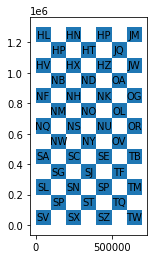

In [9]:
from pandas import DataFrame
from geopandas import GeoDataFrame, GeoSeries

pdf = DataFrame(data)

gpdf = GeoDataFrame(
    pdf,
    geometry=GeoSeries.from_wkb(pdf["geometry"]),
)

plt = gpdf.plot()

for index, row in gpdf.iterrows():
    plt.annotate(
        text=row["bng_index"],
        xy=row["geometry"].centroid.coords[:][0],
        horizontalalignment='center',
        verticalalignment='center',
    )

In [10]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()

In [11]:
sdf = spark.createDataFrame(
    data=data,
    schema=schema,
)

In [12]:
sdf.show()

+-----+----+------+-----------+--------------------+--------------+--------------------+---------------+---------+--------------------+--------------------+
| bool|int8| int16|      int32|               int64|       float32|             float64|string_category|bng_index|              bounds|            geometry|
+-----+----+------+-----------+--------------------+--------------+--------------------+---------------+---------+--------------------+--------------------+
| true|-128|-32768|-2147483648|-9223372036854775808|1.17549435E-38|2.225073858507201...|              A|       HL|[0, 1200000, 1000...|[01 03 00 00 00 0...|
|false|-123|-31312|-2052039931|-8813444390772341760|    7.56183E36|3.994873633027368...|              B|       HN|[200000, 1200000,...|[01 03 00 00 00 0...|
| true|-117|-29856|-1956596213|-8403516744689906688|   1.512366E37|7.989747266054736...|              C|       HP|[400000, 1200000,...|[01 03 00 00 00 0...|
|false|-111|-28399|-1861152495|-7993589098607472640|   2.2

In [13]:
from sds_data_model.dataframe import DataFrameWrapper

dfw = DataFrameWrapper(
    name="geometry_mask",
    data=sdf,
    metadata=None,
)

In [17]:
dfw.to_zarr("zarrs/actual_geometry_mask.zarr", overwrite=True)

In [18]:
from sds_data_model.raster import DatasetWrapper

dsw = DatasetWrapper.from_files("zarrs/actual_geometry_mask.zarr")

In [19]:
from itertools import repeat

import rioxarray
from affine import Affine
from dask.array import ones, zeros, concatenate, arange
from more_itertools import interleave_longest, chunked
from numpy import uint8
from xarray import DataArray 

from sds_data_model.constants import (
    OUT_SHAPE,
    BNG_YMAX,
    CELL_SIZE,
    BNG_YMIN,
    BNG_XMIN,
    BNG_XMAX,
)


_ones = ones(dtype=uint8, shape=OUT_SHAPE, chunks=(10_000, 10_000))
_zeros = zeros(dtype=uint8, shape=OUT_SHAPE, chunks=(10_000, 10_000))

interleaved = interleave_longest(
    repeat(_ones, 46),
    repeat(_zeros, 45),
)

data = concatenate(
    (concatenate(chunk, axis=1) for chunk in chunked(interleaved, 7)),
    axis=0
)

coords = {
    "northings": arange(BNG_YMAX - (CELL_SIZE / 2), BNG_YMIN, -CELL_SIZE),
    "eastings": arange(BNG_XMIN + (CELL_SIZE / 2), BNG_XMAX, CELL_SIZE),
}

ds = (
    DataArray(
        name="geometry_mask",
        data=data,
        coords=coords,
        attrs={"No data": 0},
    )
    .to_dataset()
)

transform = Affine(CELL_SIZE, 0, BNG_XMIN, 0, -CELL_SIZE, BNG_YMAX)

ds.rio.write_crs("EPSG:27700", inplace=True)
ds.rio.write_transform(transform, inplace=True)

<xarray.Dataset>
Dimensions:        (northings: 130000, eastings: 70000)
Coordinates:
  * northings      (northings) float64 1.3e+06 1.3e+06 1.3e+06 ... 25.0 15.0 5.0
  * eastings       (eastings) float64 5.0 15.0 25.0 35.0 ... 7e+05 7e+05 7e+05
    spatial_ref    int64 0
Data variables:
    geometry_mask  (northings, eastings) uint8 dask.array<chunksize=(10000, 10000), meta=np.ndarray>

In [20]:
dsw.dataset = dsw.dataset.chunk(10_000, 10_000)

In [21]:
from xarray.testing import assert_identical

assert_identical(dsw.dataset, ds)

AssertionError: Left and right Dataset objects are not identical


Differing data variables:
L   geometry_mask  (northings, eastings) uint8 dask.array<chunksize=(10000, 10000), meta=np.ndarray>
    No data: 0
R   geometry_mask  (northings, eastings) uint8 dask.array<chunksize=(10000, 10000), meta=np.ndarray>
    No data: 0


In [22]:
from dask import config
from dask.array import any

y_ranges = [range(y, y + 10_000) for y in range(0, 130_000, 10_000)]
x_ranges = [range(x, x + 10_000) for x in range(0, 70_000, 10_000)]

with config.set(**{'array.slicing.split_large_chunks': False}):
    for y_range in y_ranges:
        for x_range in x_ranges:
            dsw_chunk = dsw.dataset["geometry_mask"][y_range, x_range]
            ds_chunk = ds["geometry_mask"][y_range, x_range]
            if any(dsw_chunk != ds_chunk):
                print(f"ERROR: chunks not equal at index [{y_range}, {x_range}]")

ERROR: chunks not equal at index [range(10000, 20000), range(10000, 20000)]
ERROR: chunks not equal at index [range(110000, 120000), range(10000, 20000)]


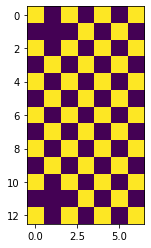

In [23]:
from itertools import product

from numpy import array
from dask import config
from dask.array import any
from matplotlib.pyplot import imshow

y_ranges = [range(y, y + 10_000) for y in range(0, 130_000, 10_000)]
x_ranges = [range(x, x + 10_000) for x in range(0, 70_000, 10_000)]

with config.set(**{'array.slicing.split_large_chunks': False}):
    sums = array([dsw.dataset["geometry_mask"][y_range, x_range].values.sum() // 100_000_000 for y_range, x_range in product(y_ranges, x_ranges)]).reshape((13, 7))

imshow(sums)

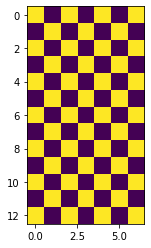

In [24]:
from itertools import product

from numpy import array
from dask import config
from dask.array import any
from matplotlib.pyplot import imshow

y_ranges = [range(y, y + 10_000) for y in range(0, 130_000, 10_000)]
x_ranges = [range(x, x + 10_000) for x in range(0, 70_000, 10_000)]

with config.set(**{'array.slicing.split_large_chunks': False}):
    sums = array([ds["geometry_mask"][y_range, x_range].values.sum() // 100_000_000 for y_range, x_range in product(y_ranges, x_ranges)]).reshape((13, 7))

imshow(sums)